In [1]:
import cv2
import torch
import time

from mmdet.apis import show_result_pyplot
from mmdet.apis import  init_detector
from mmdet.apis import inference_detector

from mmpose.apis import init_pose_model
from mmpose.apis import vis_pose_result
from mmpose.apis import inference_bottom_up_pose_model
from mmpose.apis import inference_top_down_pose_model

%matplotlib inline
import matplotlib.pyplot as plt

(416, 620, 3)


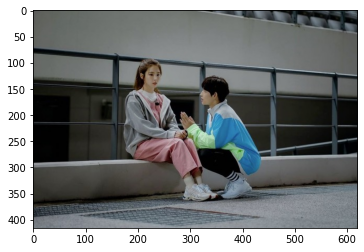

In [2]:
img = cv2.imread('../../../data/images/example1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(img.shape)
plt.imshow(img);


# BottomUp method

## Model

In [3]:
bottomup_config = '../../../configs/pose/bottom_up/udp/coco/higher_hrnet48_coco_512x512_udp.py'
bottomup_checkpoint = 'https://download.openmmlab.com/mmpose/bottom_up/higher_hrnet48_coco_512x512_udp-7cad61ef_20210222.pth'

udp_model = init_pose_model(
                config = bottomup_config,
                checkpoint = bottomup_checkpoint,
                device = 'cuda:0'
)

Use load_from_http loader


## Result

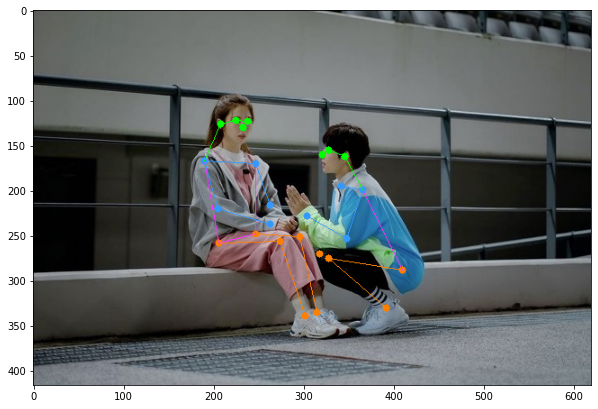

In [4]:
pose_result, _ = inference_bottom_up_pose_model(model=udp_model, img_or_path=img)

vis = vis_pose_result(model=udp_model, img=img, result=pose_result)

plt.figure(figsize=(10, 10))
plt.imshow(vis);

# TopDown Method

In [5]:
det_config = '../../../configs/detection/yolo/yolov3_d53_mstrain-608_273e_coco.py'
det_checkpoint = 'http://download.openmmlab.com/mmdetection/v2.0/yolo/yolov3_d53_mstrain-608_273e_coco/yolov3_d53_mstrain-608_273e_coco-139f5633.pth'
yolo_model = init_detector(
    config=det_config,
    checkpoint=det_checkpoint,
    device='cuda:0'
)

Use load_from_http loader


In [6]:
def process_mmdet_results(mmdet_results, cat_id=0):
    """Process mmdet results, and return a list of bboxes.
    :param mmdet_results:
    :param cat_id: category id (default: 0 for human)
    :return: a list of detected bounding boxes
    """
    if isinstance(mmdet_results, tuple):
        det_results = mmdet_results[0]
    else:
        det_results = mmdet_results

    bboxes = det_results[cat_id]

    person_results = []
    for bbox in bboxes:
        person = {}
        person['bbox'] = bbox
        person_results.append(person)

    return person_results

In [7]:
out =  inference_detector(model=yolo_model, imgs=img)

pre_out = process_mmdet_results(out)

/home/namirinz/git-clones/mmdetection/mmdet/datasets/utils.py:64: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  warnings.warn(


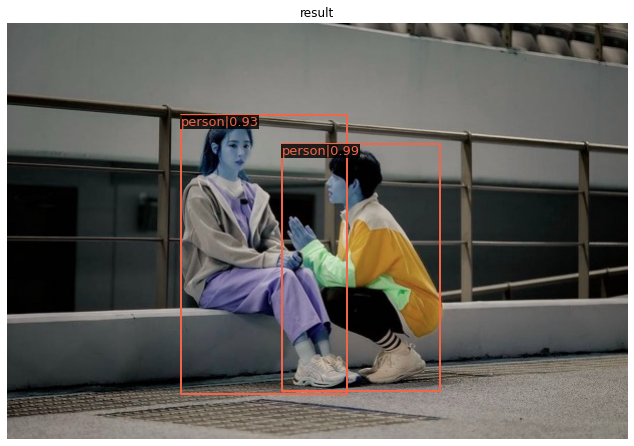

In [8]:
show_result_pyplot(model=yolo_model, img=img, result=out)

In [9]:
topdown_config = '../../../configs/pose/top_down/darkpose/coco/res50_coco_256x192_dark.py'
topdown_checkpoint = 'https://download.openmmlab.com/mmpose/top_down/resnet/res50_coco_256x192_dark-43379d20_20200709.pth'

pose_model = init_pose_model(
                config=topdown_config,
                checkpoint=topdown_checkpoint,
                device = 'cuda:0'
)

next(pose_model.parameters()).get_device()

Use load_from_http loader


0

In [10]:
out =  inference_detector(model=yolo_model, imgs=img)
pre_out = process_mmdet_results(out)

pose_results,_ = inference_top_down_pose_model(
    model = pose_model, 
    img_or_path = img,
    person_results = pre_out, bbox_thr=0.3, format='xyxy',
    return_heatmap=True
)

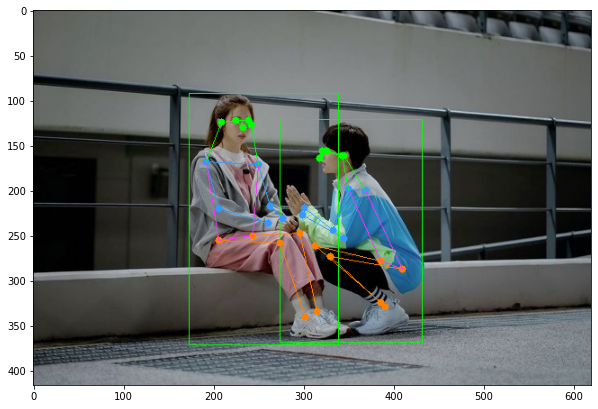

In [11]:
vis_result = vis_pose_result(
        model = pose_model,
        img = img,
        result = pose_results, kpt_score_thr=0,
)

plt.figure(figsize=(10, 10))
plt.imshow(vis_result);

# Running on Video

In [16]:
import time
from IPython.display import clear_output

torch.backends.cudnn.benchmark = True

video_path = '../../../data/videos/example1.mp4'
cap = cv2.VideoCapture(video_path)

fps = cap.get(cv2.CAP_PROP_FPS)
size = (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))

print(size, fps)

(854, 480) 29.97002997002997


In [17]:
FONT_SCALE = 1.0
FONT_FACE = cv2.FONT_HERSHEY_SIMPLEX
FONT_COLOR = (39, 0, 247)
FONT_THICKNESS = 2

## Top-Down Video

In [18]:
while (cap.isOpened()):

    flag, img = cap.read()
    if not flag:
        break
    s1 = time.time()

    # test a single image, the resulting box is (x1, y1, x2, y2)
    mmdet_results = inference_detector(yolo_model, img)

    time_det = time.time()-s1
        
    # keep the person class bounding boxes.
    person_results = process_mmdet_results(mmdet_results)

    s2 = time.time()

    # test aq single image, with a list of bboxes.
    if len(person_results) == 0:
        vis_img = img
        time_pose = time.time() - s2
    else:
        pose_results, _ = inference_top_down_pose_model(
                            model=pose_model,
                            img_or_path=img,
                            person_results=person_results,
                            bbox_thr=0.3,
                            format='xyxy',
                            
        )
        time_pose = time.time() - s2
        
        # show the results
        vis_img = vis_pose_result(
                    model=pose_model,
                    img=img,
                    result=pose_results,
                    kpt_score_thr=0.3,
                    show=False
        )

    fps_process = 1 / (time.time()-s1)
    
    cv2.putText(vis_img,f'FPS {fps_process:.2f}', (15, 50),  FONT_FACE, FONT_SCALE, FONT_COLOR, FONT_THICKNESS)
    
    cv2.putText(vis_img,f'Detection {1/time_det:.2f}', (15, 75),  FONT_FACE, FONT_SCALE, FONT_COLOR, FONT_THICKNESS)
    cv2.putText(vis_img,f'Pose {1/time_pose:.2f}', (15, 100),  FONT_FACE, FONT_SCALE, FONT_COLOR, FONT_THICKNESS)
    
    cv2.imshow('Image', vis_img)
    
    if cv2.waitKey(1) == ord('k'):
        break

cap.release()   
cv2.destroyAllWindows()

## Bottom-Up Video

In [21]:
video_path = '../../../data/videos/example1.mp4'
cap = cv2.VideoCapture(video_path)

In [22]:
while (cap.isOpened()):
    flag, img = cap.read()
    if not flag:
        break
    s1 = time.time()

    # test aq single image, with a list of bboxes.
    pose_result, _ = inference_bottom_up_pose_model(
                        model=udp_model,
                        img_or_path=img
    )
    
    time_pose = time.time() - s2
    
    s3 = time.time()
    # show the results
    vis_img = vis_pose_result(
                model=udp_model,
                img=img,
                result=pose_result,
                kpt_score_thr=0.3,
                show=False
    )

    fps_process = 1 / (time.time()-s1)
    
    cv2.putText(vis_img,f'FPS {fps_process:.2f}', (15, 30),  FONT_FACE, 0.5, FONT_COLOR, FONT_THICKNESS)    
    cv2.imshow('Image', vis_img)
    
    if cv2.waitKey(1) == ord('k'):
        break

cap.release()   
cv2.destroyAllWindows()